In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [3]:
import lanelines
import roadplane
import straightlanespipeline as slp 

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [4]:
im_straight_1 = lanelines.open_image('test_images/straight_lines1.jpg')
im_straight_2 = lanelines.open_image('test_images/straight_lines2.jpg')

test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]

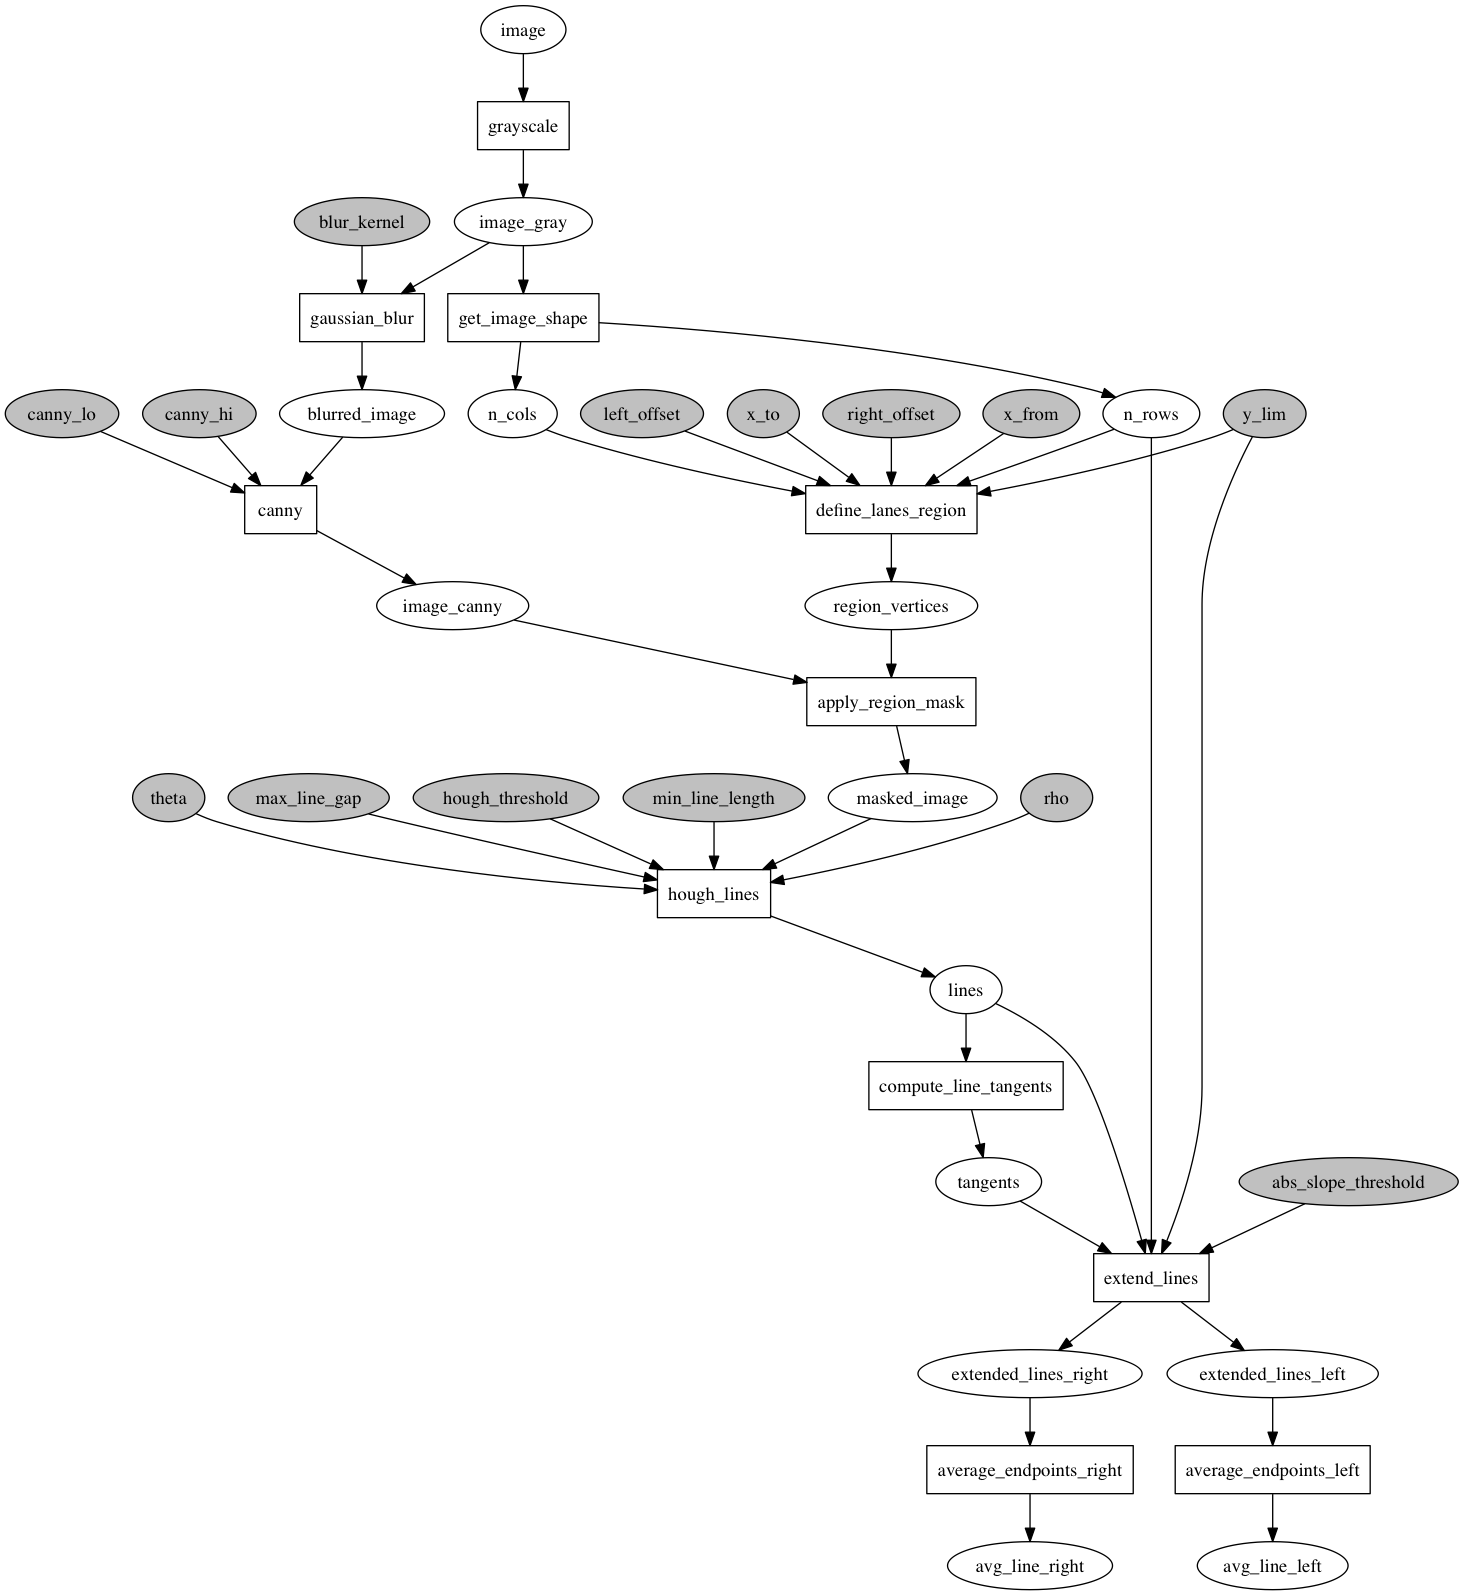

In [5]:
cg = slp.computational_graph
cg_params = slp.parameters

runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

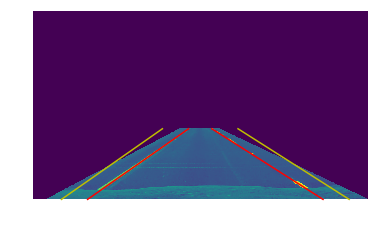

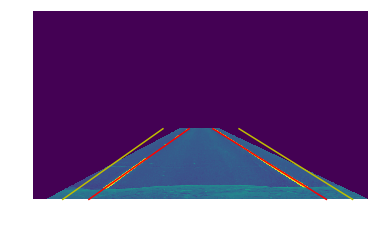

In [6]:
for im in (im_straight_1, im_straight_2):
    runner.run(image=im)
    
    plt.figure()
    plt.imshow( lanelines.apply_region_mask(runner['image_gray'], runner['region_vertices']) )
    plt.axis("off")
    
    lanelines.plot_line(runner['avg_line_left'], color='r')
    lanelines.plot_line(runner['avg_line_right'], color='r')
    
    lanelines.plot_line( lanelines.move_line(runner['avg_line_left'], -100), color='y')
    lanelines.plot_line( lanelines.move_line(runner['avg_line_right'], 100), color='y')

In [7]:
def warp_road_image(im, canvas_sz, src, dst):

    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im, M, canvas_sz, flags=cv2.INTER_LINEAR)

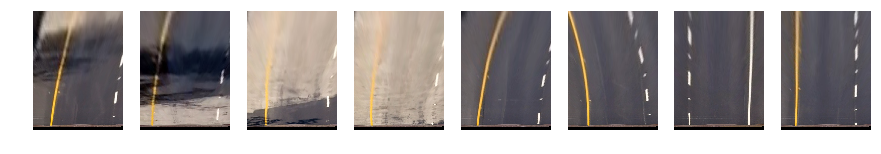

In [8]:
src = roadplane.define_flat_plane_on_road((im_straight_1, im_straight_2), x_offset=0)
#src[0] += 0.2
canvas_sz = (600, 800)
dst = lanelines.get_rectangle_corners_in_image(canvas_sz, offset_x=100, offset_y=20)

plt.figure(figsize=(15, 5))
for i, im in enumerate(test_images):
    plt.subplot(1, 8, i+1)
    warped = warp_road_image(im, canvas_sz, src, dst)
    plt.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
    plt.axis('off')